In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import os
import re
import json
from datetime import datetime
import pickle
import time
import seaborn as sns
import matplotlib.pyplot as plt

from scrape_tdf_data import *  # import helper functions

%matplotlib inline

### Load `year_links_num_dict`

In [3]:
year_links_num_dict = load_pickle('year_links_num_dict')

In [4]:
year_links_num_dict

{1903: {'mainurl': '/en/block/history/10707/d0ab6a216569236433268b7f19e1776c',
  'ranking_url': '/en/block/history/10707/ranking/c4eb59986a1ba20371a3df6c74ceb25b',
  'starters_url': '/en/block/history/10707/starters/df151b25da25a66cf629b8098211c08c',
  'the_race_url': '/en/block/history/10707/the_race/3679370d92b2c33c963ce44566d6da93',
  'stages_url': '/en/block/history/10707/stages/d2ee4f144d6a7ce9bcad5d7aada4b86d',
  'jersey_wearers_url': '/en/block/history/10707/jerseys/d92fd8558eb3e81c7e5d199a96c031eb',
  'stages_winners_url': '/en/block/history/10707/winners/fb20799446ca7516bcf7a9844bda488a',
  'num_of_stages': 6},
 1904: {'mainurl': '/en/block/history/10708/0b76b8f809ad5d8bcf3579df597644d8',
  'ranking_url': '/en/block/history/10708/ranking/357e5c608514340a1b3d2bff0fd396c7',
  'starters_url': '/en/block/history/10708/starters/7fcff3460678d7b275f79e468d02dd05',
  'the_race_url': '/en/block/history/10708/the_race/ddd82648a02bd8fcebda0a33f61b0d4a',
  'stages_url': '/en/block/history

## Building data visualizations

### 1. Stages - Construct the main df

In [331]:
stages_df = load_pickle('stages_all')
print(stages_df.shape)
stages_df.head()

(2259, 5)


year stage_num date_start                start_city        finish_city
0  2018   Stage 1 2018-07-07      Noirmoutier-en-l'Île  Fontenay-le-Comte
1  2018   Stage 2 2018-08-07  Mouilleron-Saint-Germain   La Roche-sur-Yon
2  2018   Stage 3 2018-09-07                    Cholet             Cholet
3  2018   Stage 4 2018-10-07                  La Baule            Sarzeau
4  2018   Stage 5 2018-11-07                   Lorient            Quimper

#### Plot number of stages over time

In [332]:
num_stages_ea_year = pd.DataFrame(stages_df.groupby(['year']).size().reset_index())
num_stages_ea_year.columns = ['year','num_of_stages']
num_stages_ea_year.head()

year  num_of_stages
0  1903              6
1  1904              6
2  1905             11
3  1906             14
4  1907             14

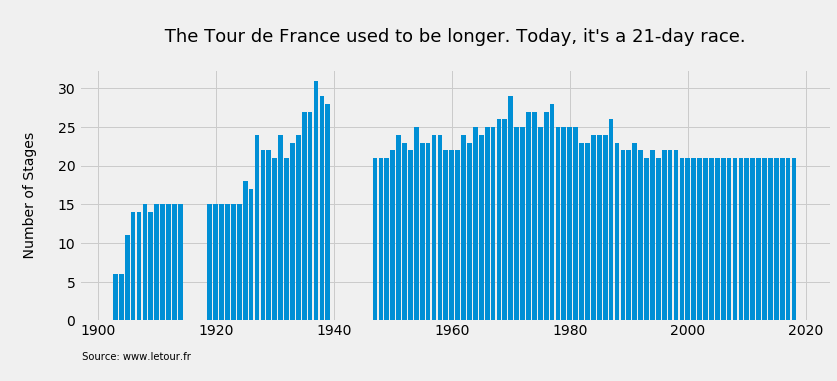

In [333]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
plt.gcf().subplots_adjust(top=0.85, bottom=0.15)

data = num_stages_ea_year.copy()

ax.bar(data.year, data.num_of_stages)
ax.set_title("\n The Tour de France used to be longer. Today, it's a 21-day race. \n", size=18)
# plt.xlabel('\n ', size=14)
plt.ylabel('\n Number of Stages \n', size=14)
plt.annotate('\n Source: www.letour.fr \n', (0,0), (0, -20), xycoords='axes fraction', textcoords='offset points', va='top', size=10)
plt.savefig(os.getcwd() + '/img/00_num_stages_over_time.png')

#### Prep for a chord chart or bump chart?

In [334]:
stages_df[stages_df.stage_num == 'Stage 1'].start_city.value_counts()
stages_df.finish_city.value_counts().head()

Paris       97
Bordeaux    79
Pau         61
Luchon      45
Metz        38
Name: finish_city, dtype: int64

### 2. Stage winners - Construct the main df

In [335]:
stage_winners_df = load_pickle('stage_winners_all')
print(stage_winners_df.shape)
stage_winners_df.head()

(2196, 5)


year  stage_num                                     parcours  \
0  2018        1.0     Noirmoutier-en-l'Île > Fontenay-le-Comte   
1  2018        2.0  Mouilleron-Saint-Germain > La Roche-sur-Yon   
2  2018        4.0                           La Baule > Sarzeau   
3  2018        5.0                            Lorient > Quimper   
4  2018        6.0            Brest > Mûr-de-Bretagne Guerlédan   

                    winner                   team  
0  FERNANDO GAVIRIA RENDON  (QUICK - STEP FLOORS)  
1              PETER SAGAN     (BORA - HANSGROHE)  
2  FERNANDO GAVIRIA RENDON  (QUICK - STEP FLOORS)  
3              PETER SAGAN     (BORA - HANSGROHE)  
4            DANIEL MARTIN    (UAE TEAM EMIRATES)

How informative is the total number of stage winners over time?

In [ ]:
stage_winners_df.groupby(['year','winner']).size().sort_values(ascending=False).head(10)

### 3. Jersey wearers - Construct the main df

In [336]:
jersey_wearers_df = load_pickle('jersey_wearers_all')
print(jersey_wearers_df.shape)
jersey_wearers_df.head()

(2259, 6)


year  stage_num            yellow_jersey        green_jersey  \
0  2018        1.0  FERNANDO GAVIRIA RENDON       MARCEL KITTEL   
1  2018        2.0              PETER SAGAN  ALEXANDER KRISTOFF   
2  2018        3.0        GREG VAN AVERMAET         PETER SAGAN   
3  2018        4.0        GREG VAN AVERMAET         PETER SAGAN   
4  2018        5.0        GREG VAN AVERMAET         PETER SAGAN   

  polka_dot_jersey             white_jersey  
0   KEVIN LEDANOIS        DYLAN GROENEWEGEN  
1       DION SMITH  FERNANDO GAVIRIA RENDON  
2       DION SMITH     SØREN KRAGH ANDERSEN  
3       DION SMITH     SØREN KRAGH ANDERSEN  
4     TOMS SKUJINS     SØREN KRAGH ANDERSEN

In [337]:
s = jersey_wearers_df.yellow_jersey.value_counts()
idx = s[s>5].index
yellow_5 = jersey_wearers_df[jersey_wearers_df.yellow_jersey.isin(idx)]
yellow_5.shape

(1738, 6)

In [338]:
yellows_over_time = pd.DataFrame(yellow_5.groupby(['yellow_jersey','year']).size().reset_index())
yellows_over_time.columns = ['rider','year','num_of_yellow_jerseys']
yellows_over_time.head()

rider  year  num_of_yellow_jerseys
0     ADELIN BENOIT  1925                      6
1  ALBERTO CONTADOR  2007                      4
2  ALBERTO CONTADOR  2009                      7
3      ALBERTO ELLI  2000                     16
4   ANDRÉ DARRIGADE  1956                      6

In [339]:
yellows_over_time['cum_yellows'] = yellows_over_time.groupby('rider')['num_of_yellow_jerseys'].apply(lambda x: x.cumsum())
yellows_over_time.head()

rider  year  num_of_yellow_jerseys  cum_yellows
0     ADELIN BENOIT  1925                      6            6
1  ALBERTO CONTADOR  2007                      4            4
2  ALBERTO CONTADOR  2009                      7           11
3      ALBERTO ELLI  2000                     16           16
4   ANDRÉ DARRIGADE  1956                      6            6

In [340]:
len(yellows_over_time.rider.unique())

105

#### Plotting yellow jerseys over time

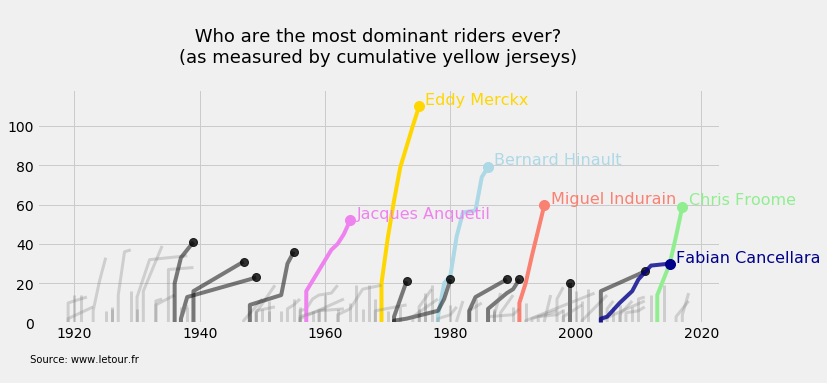

In [341]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
plt.gcf().subplots_adjust(top=0.8, bottom=0.15, right=0.87)

data = yellows_over_time.copy()

for rider in list(data.rider.unique()):
    d = data[data.rider == rider]
    first_row = pd.DataFrame([{'rider':None, 'year':None, 'cum_yellows':0}])
    d = pd.concat([first_row, d], sort=False).fillna(method='bfill')
    final_year = d.tail(1)

    if rider == 'EDDY MERCKX':
        ax.plot(d.year, d.cum_yellows, color='gold', alpha=1.0)
        plt.text(d.year.max()+1, d.cum_yellows.max()+1,rider.title(), size=16, color='gold')
        plt.plot(final_year.year, final_year.cum_yellows, marker='o', markersize=10, color='gold')
    elif rider == 'BERNARD HINAULT':
        ax.plot(d.year, d.cum_yellows, color='lightblue', alpha=1.0)
        plt.text(d.year.max()+1, d.cum_yellows.max()+1.5,rider.title(), size=16, color='lightblue')
        plt.plot(final_year.year, final_year.cum_yellows, marker='o', markersize=10, color='lightblue')
    elif rider == 'MIGUEL INDURAIN':
        ax.plot(d.year, d.cum_yellows, color='salmon', alpha=1.0)
        plt.text(d.year.max()+1, d.cum_yellows.max()+1,rider.title(), size=16, color='salmon')
        plt.plot(final_year.year, final_year.cum_yellows, marker='o', markersize=10, color='salmon')
    elif rider == 'CHRIS FROOME':
        ax.plot(d.year, d.cum_yellows, color='lightgreen', alpha=1.0)
        plt.text(d.year.max()+1, d.cum_yellows.max()+1.5,rider.title(), size=16, color='lightgreen')
        plt.plot(final_year.year, final_year.cum_yellows, marker='o', markersize=10, color='lightgreen')
    elif rider == 'JACQUES ANQUETIL':
        ax.plot(d.year, d.cum_yellows, color='violet', alpha=1.0)
        plt.text(d.year.max()+1, d.cum_yellows.max()+1,rider.title(), size=16, color='violet')
        plt.plot(final_year.year, final_year.cum_yellows, marker='o', markersize=10, color='violet')
    elif rider == 'FABIAN CANCELLARA':
        ax.plot(d.year, d.cum_yellows, color='darkblue', alpha=0.8, zorder=10)
        plt.text(d.year.max()+1, d.cum_yellows.max()+1,rider.title(), size=16, color='darkblue')
        plt.plot(final_year.year, final_year.cum_yellows, marker='o', markersize=10, color='darkblue')
    elif rider in ['LOUISON BOBET','RENÉ VIETTO','FABIAN CANCELLARA','THOMAS VOECKLER','GINO BARTALI','JOOP ZOETEMELK',
                   'GREG LEMOND','LAURENT FIGNON','LUIS OCANA','SYLVÈRE MAES','JAAN KIRSIPUU']:
        ax.plot(d.year, d.cum_yellows, color='black', alpha=0.5)
        plt.plot(final_year.year, final_year.cum_yellows, marker='o', markersize=8, color='black', alpha=0.8)
    else:
        ax.plot(d.year, d.cum_yellows, color='grey', alpha=0.3, linewidth=3)
    
plt.title('\n Who are the most dominant riders ever? \n(as measured by cumulative yellow jerseys)\n', size=18)
# plt.xlabel('\n ', size=14)
# plt.ylabel('\n ', size=14)
plt.ylim(0,119)
plt.annotate('\n Source: www.letour.fr \n', (0,0), (-10, -20), xycoords='axes fraction', textcoords='offset points', va='top', size=10)
plt.savefig(os.getcwd() + '/img/01_cumulative_yellow_jerseys_over_time.png')

In [342]:
yellows_over_time.groupby('rider')['cum_yellows'].max().sort_values(ascending=False).head(20)

rider
EDDY MERCKX           110
BERNARD HINAULT        79
MIGUEL INDURAIN        60
CHRIS FROOME           59
JACQUES ANQUETIL       52
SYLVÈRE MAES           41
ANTONIN MAGNE          39
NICOLAS FRANTZ         37
LOUISON BOBET          36
ANDRÉ LEDUCQ           34
OTTAVIO BOTTECCHIA     33
RENÉ VIETTO            31
FABIAN CANCELLARA      30
ROMAIN MAES            28
THOMAS VOECKLER        26
GINO BARTALI           23
LAURENT FIGNON         22
JOOP ZOETEMELK         22
GREG LEMOND            22
LUIS OCANA             21
Name: cum_yellows, dtype: int64

#### Bump chart for 2018 race

In [343]:
rankings_2018 = pd.read_csv('data/2018/2018_rankings_itg.csv')
rankings_2018 = rankings_2018.rename(columns={'rank':'ranking'})
print(rankings_2018.shape)
rankings_2018.head()

(3351, 9)


stage_num  ranking                    rider  rider_no  \
0          1        1  FERNANDO GAVIRIA RENDON       103   
1          1        2              PETER SAGAN       111   
2          1        3            MARCEL KITTEL       144   
3          1        4            OLIVER NAESEN        27   
4          1        5       ALEXANDER KRISTOFF        95   

                   team         times             gap    b    p  
0   QUICK - STEP FLOORS  04h 23' 22''               -  10'  NaN  
1      BORA - HANSGROHE  04h 23' 26''  + 00h 00' 04''  06'  NaN  
2  TEAM KATUSHA ALPECIN  04h 23' 28''  + 00h 00' 06''  04'  NaN  
3      AG2R LA MONDIALE  04h 23' 31''  + 00h 00' 09''  01'  NaN  
4     UAE TEAM EMIRATES  04h 23' 32''  + 00h 00' 10''  NaN  NaN

In [344]:
len(list(data.rider.unique())) # 81 riders in 176

105

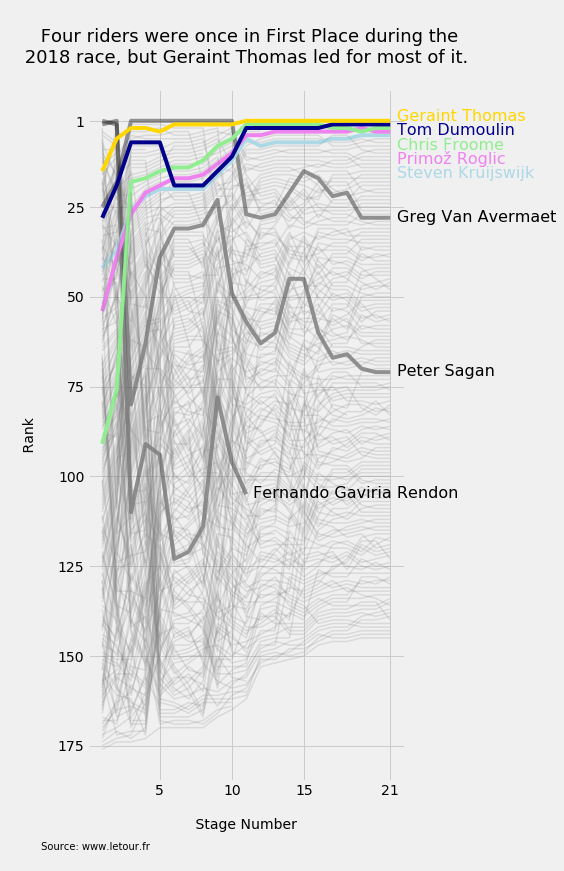

In [345]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(8,12))
ax = fig.add_subplot(111)
plt.gcf().subplots_adjust(top=0.9, bottom=0.10, left=0.15, right=0.70)

data = rankings_2018.copy()

for rider in list(data.rider.unique()):
    d = data[data.rider == rider]
    d = d[['stage_num','ranking']]
#     d.columns = ['stage_num','ranking']
    
    if rider == 'GERAINT THOMAS':
        ax.plot(d.stage_num, d.ranking, color='gold', alpha=1.0, zorder=10)
        plt.text(d.stage_num.max()+0.5, d.ranking.tail(1),rider.title(), size=16, color='gold')
    elif rider == 'TOM DUMOULIN':
        ax.plot(d.stage_num, d.ranking, color='darkblue', alpha=1.0, zorder=9)
        plt.text(d.stage_num.max()+0.5, d.ranking.tail(1)+3,rider.title(), size=16, color='darkblue')
    elif rider == 'CHRIS FROOME':
        ax.plot(d.stage_num, d.ranking, color='lightgreen', alpha=1.0)
        plt.text(d.stage_num.max()+0.5, d.ranking.tail(1)+6,rider.title(), size=16, color='lightgreen')
    elif rider == 'PRIMOŽ ROGLIC':
        ax.plot(d.stage_num, d.ranking, color='violet', alpha=1.0)
        plt.text(d.stage_num.max()+0.5, d.ranking.tail(1)+9,rider.title(), size=16, color='violet')
    elif rider == 'STEVEN KRUIJSWIJK':
        ax.plot(d.stage_num, d.ranking, color='lightblue', alpha=1.0)
        plt.text(d.stage_num.max()+0.5, d.ranking.tail(1)+12,rider.title(), size=16, color='lightblue')
    elif rider in ['GREG VAN AVERMAET', 'PETER SAGAN', 'FERNANDO GAVIRIA RENDON']:
        ax.plot(d.stage_num, d.ranking, color='black', alpha=0.4)
        plt.text(d.stage_num.tail(1)+0.5, d.ranking.tail(1)+1,rider.title(), size=16, color='black')        
    else:
        ax.plot(d.stage_num, d.ranking, color='grey', alpha=0.2, linewidth=1.5)
    
plt.gca().invert_yaxis()
ax.set_title('\n Four riders were once in First Place during the\n 2018 race, but Geraint Thomas led for most of it. \n', size=18)
ax.set_ylabel('\n Rank \n', size=14)
ax.set_xlabel('\n Stage Number \n', size=14)
ax.set_xticks([5,10,15,21])
ax.set_yticks([1,25,50,75,100,125,150,175])
plt.annotate('\n Source: www.letour.fr \n', (0,0), (-50, -50), xycoords='axes fraction', textcoords='offset points', va='top', size=10)
plt.savefig(os.getcwd() + '/img/02_rankings_2018.png')

### Bump chart for the first TDF race in 1997

In [346]:
rankings_1997 = pd.read_csv('data/1997/1997_rankings_itg.csv')
rankings_1997 = rankings_1997.rename(columns={'rank':'ranking'})
rankings_1997#.head()

stage_num  ranking                rider  rider_no  \
0             1        1      MARIO CIPOLLINI       114   
1             1        2       CHRIS BOARDMAN        91   
2             1        3          JAN ULLRICH         8   
3             1        4        TONY ROMINGER        61   
4             1        5        ABRAHAM OLANO       151   
5             1        6           TOM STEELS        27   
6             1        7       SERVAIS KNAVEN       105   
7             1        8          ERIK DEKKER       124   
8             1        9      OSCAR CAMENZIND        22   
9             1       10  FRANK VANDENBROUCKE        29   
10            1       11     LAURENT JALABERT        31   
11            1       12         JENS HEPPNER         5   
12            1       13       FRANKIE ANDREU        62   
13            1       14   FRÉDÉRIC MONCASSIN        92   
14            1       15    JEROEN BLIJLEVENS       102   
15            1       16     ARTURAS KASPUTIS       137   
16            1       17        ADRIANO BAFFI       192   
17            1       18       DANNY NELISSEN       127   
18            1       19          PASCAL LINO       211   
19            1       20           ERIK ZABEL         9   
20            1       21   MAARTEN DEN BAKKER       101   
21            1       22     DANIELE NARDELLO        25   
22            1       23      GEORGE HINCAPIE       196   
23            1       24   PETER LÜTTENBERGER       121   
24            1       25       MATTEO TOSATTO        49   
25            1       26      DAVIDE REBELLIN        77   
26            1       27        JON ODRIOZOLA       147   
27            1       28          ANDREA TAFI        28   
28            1       29        MARCO FINCATO        83   
29            1       30         LUCA COLOMBO       144   
...         ...      ...                  ...       ...   
3530         21      110          NICOLA LODA        46   
3531         21      111     FRÉDÉRIC GUESDON        72   
3532         21      112     BRUNO CENGHIALTA       143   
3533         21      113   SERGUEI OUTSCHAKOV        58   
3534         21      114   FRÉDÉRIC MONCASSIN        92   
3535         21      115    CHRISTOPHE RINERO        68   
3536         21      116      GILBERTO SIMONI        48   
3537         21      117       ROBBIE MC EWEN       126   
3538         21      118    GIOVANNI LOMBARDI         6   
3539         21      119        ADRIANO BAFFI       192   
3540         21      120          LUCA SCINTO        47   
3541         21      121     MARCELINO GARCIA        34   
3542         21      122        NICOLA MINALI       146   
3543         21      123       MIRCO CREPALDI        54   
3544         21      124            LAURI AUS       133   
3545         21      125      GERRIT DE VRIES        55   
3546         21      126    JEROEN BLIJLEVENS       102   
3547         21      127     LAURENT DESBIENS        63   
3548         21      128      TRISTAN HOFFMAN       104   
3549         21      129          CARLO FINCO        43   
3550         21      130        ROSSANO BRASI        52   
3551         21      131        PASCAL DERAME       194   
3552         21      132       MATTEO TOSATTO        49   
3553         21      133    GIANLUCA PIEROBON       148   
3554         21      134            EROS POLI        94   
3555         21      135     NICOLAS JALABERT        65   
3556         21      136      TORSTEN SCHMIDT        86   
3557         21      137      PHILIPP BUSCHOR       112   
3558         21      138       STÉPHANE CUEFF       203   
3559         21      139     PHILIPPE GAUMONT        64   

                               team         times             gap   b   p  
0                       SAECO-ESTRO  04h 48' 09''               - NaN NaN  
1                               GAN  04h 48' 19''  + 00h 00' 10'' NaN NaN  
2             TEAM DEUTSCHE TELEKOM  04h 48' 21''  + 00h 00' 12'' NaN NaN  
3                           COFIDIS  04h 48

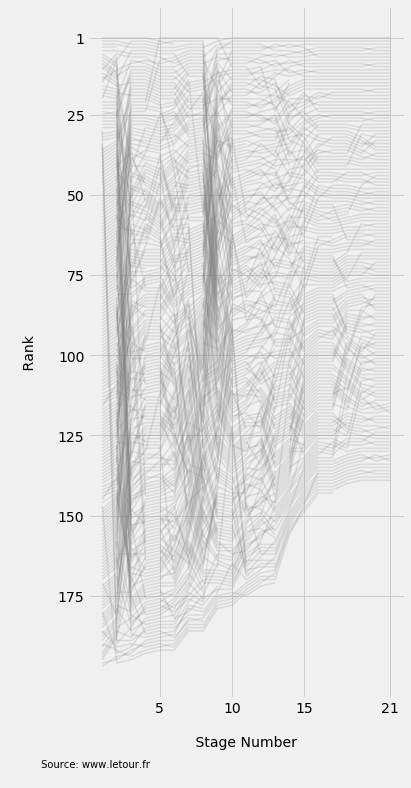

In [374]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(8,12))
ax = fig.add_subplot(111)
plt.gcf().subplots_adjust(top=0.9, bottom=0.10, left=0.15, right=0.70)

data = rankings_1997.copy()

for rider in list(data.rider.unique()):
    d = data[data.rider == rider]
    d = d[['stage_num','ranking']]
#     d.columns = ['stage_num','ranking']
    
#     if rider == 'GERAINT THOMAS':
#         ax.plot(d.stage_num, d.ranking, color='gold', alpha=1.0, zorder=10)
#         plt.text(d.stage_num.max()+0.5, d.ranking.tail(1),rider.title(), size=16, color='gold')
#     elif rider == 'TOM DUMOULIN':
#         ax.plot(d.stage_num, d.ranking, color='darkblue', alpha=1.0, zorder=9)
#         plt.text(d.stage_num.max()+0.5, d.ranking.tail(1)+3,rider.title(), size=16, color='darkblue')
#     elif rider == 'CHRIS FROOME':
#         ax.plot(d.stage_num, d.ranking, color='lightgreen', alpha=1.0)
#         plt.text(d.stage_num.max()+0.5, d.ranking.tail(1)+6,rider.title(), size=16, color='lightgreen')
#     elif rider == 'PRIMOŽ ROGLIC':
#         ax.plot(d.stage_num, d.ranking, color='violet', alpha=1.0)
#         plt.text(d.stage_num.max()+0.5, d.ranking.tail(1)+9,rider.title(), size=16, color='violet')
#     elif rider == 'STEVEN KRUIJSWIJK':
#         ax.plot(d.stage_num, d.ranking, color='lightblue', alpha=1.0)
#         plt.text(d.stage_num.max()+0.5, d.ranking.tail(1)+12,rider.title(), size=16, color='lightblue')
#     elif rider in ['GREG VAN AVERMAET', 'PETER SAGAN', 'FERNANDO GAVIRIA RENDON']:
#     ax.plot(d.stage_num, d.ranking, color='black', alpha=0.4)
#     plt.text(d.stage_num.tail(1)+0.5, d.ranking.tail(1)+1,rider.title(), size=16, color='black')        
#     else:
    ax.plot(d.stage_num, d.ranking, color='grey', alpha=0.2, linewidth=1.5)
    
plt.gca().invert_yaxis()
# ax.set_title('\n Four riders were once in First Place during the\n 2018 race, but Geraint Thomas led for most of it. \n', size=18)
ax.set_ylabel('\n Rank \n', size=14)
ax.set_xlabel('\n Stage Number \n', size=14)
ax.set_xticks([5,10,15,21])
ax.set_yticks([1,25,50,75,100,125,150,175])
plt.annotate('\n Source: www.letour.fr \n', (0,0), (-50, -50), xycoords='axes fraction', textcoords='offset points', va='top', size=10)
plt.savefig(os.getcwd() + '/img/03_rankings_1997.png')

## Explore merging in country names

In [348]:
starters_df = load_pickle('starters_all')
print(starters_df.shape)
starters_df.head()

(15001, 5)


year      team  rider_num               rider_name nationality
0  2018  TEAM SKY          1             CHRIS FROOME         gbr
1  2018  TEAM SKY          2  EGAN ARLEY BERNAL GOMEZ         col
2  2018  TEAM SKY          3     JONATHAN CASTROVIEJO         esp
3  2018  TEAM SKY          4       MICHAL KWIATKOWSKI         pol
4  2018  TEAM SKY          5            GIANNI MOSCON         ita

In [349]:
starters.groupby('year').size()

year
1903     84
1904     88
1905     60
1906     78
1907     93
1908    111
1909    150
1910    110
1911     84
1912    131
1913    140
1914    145
1919     67
1920    113
1921    123
1922    120
1923    139
1924    158
1925    129
1926    126
1927    142
1928    162
1929    155
1930    100
1931     81
1932     80
1933     80
1934     60
1935     93
1936     90
       ... 
1989    198
1990    198
1991    198
1992    198
1993    180
1994    189
1995    189
1996    198
1997    198
1998    189
1999    180
2000    180
2001    189
2002    189
2003    198
2004    188
2005    189
2006    176
2007    189
2008    180
2009    180
2010    198
2011    198
2012    198
2013    198
2014    198
2015    198
2016    198
2017    198
2018    176
Length: 105, dtype: int64

#### Plot number of riders at the start of each TDF over time

What year did the most riders not finish??!

Pull in country names and IOC country codes from `countries_ioc_codes.csv`

In [350]:
ioc = pd.read_csv('data/country_ioc_codes.csv')
ioc.ioc_code = ioc.ioc_code.str.lower()
ioc.country = ioc.country.str.lower()
print(ioc.shape)
ioc.tail()

(208, 2)


ioc_code                           country
203      vin  saint vincent and the grenadines
204      yem                             yemen
205      yug                        yugoslavia
206      zam                            zambia
207      zim                          zimbabwe

In [351]:
merged_df = pd.merge(starters_df, ioc, how='left', left_on='nationality',right_on='ioc_code')

List of country codes that **_couldn't_** be matched

In [352]:
merged_df[merged_df.country.isnull()]  # looks good!

Empty DataFrame
Columns: [year, team, rider_num, rider_name, nationality, ioc_code, country]
Index: []

List of country codes that **_did match_**

In [353]:
merged_df[merged_df.country.isnull() == False].shape  # looks good!

(15001, 7)

#### Plot top nationality of riders over the entire time period

In [354]:
m = merged_df.copy()
m.head()

year      team  rider_num               rider_name nationality ioc_code  \
0  2018  TEAM SKY          1             CHRIS FROOME         gbr      gbr   
1  2018  TEAM SKY          2  EGAN ARLEY BERNAL GOMEZ         col      col   
2  2018  TEAM SKY          3     JONATHAN CASTROVIEJO         esp      esp   
3  2018  TEAM SKY          4       MICHAL KWIATKOWSKI         pol      pol   
4  2018  TEAM SKY          5            GIANNI MOSCON         ita      ita   

         country  
0  great britain  
1       colombia  
2          spain  
3         poland  
4          italy

In [384]:
all_riders = m.groupby(['rider_name','country']).size().reset_index()
all_riders.columns = ['rider_name','country','times_raced_in_tdf']
all_riders.sort_values('times_raced_in_tdf', ascending=False).head()

rider_name        country  times_raced_in_tdf
4804  SYLVAIN CHAVANEL         france                  18
1816   GEORGE HINCAPIE  united states                  17
4788    STUART O'GRADY      australia                  17
2650        JENS VOIGT        germany                  17
2728    JOOP ZOETEMELK    netherlands                  16

In [362]:
m.country.value_counts(ascending=False)#.plot(kind='bar');

france            5416
belgium           2133
italy             1759
spain             1482
netherlands        920
switzerland        547
germany            542
colombia           222
great britain      217
united states      213
australia          210
luxembourg         188
denmark            161
russia             115
portugal            87
austria             82
norway              62
poland              60
ireland             59
kazakhstan          49
ukraine             47
slovenia            41
czech republic      39
new zealand         38
sweden              35
canada              28
estonia             27
south africa        26
lithuania           23
belarus             20
slovakia            15
mexico              12
latvia              12
algeria             12
japan               11
croatia             10
venezuela            9
soviet union         9
uzbekistan           9
brazil               8
argentina            7
yugoslavia           6
finland              6
morocco    

In [357]:
num_stages_ea_year

year  num_of_stages
0    1903              6
1    1904              6
2    1905             11
3    1906             14
4    1907             14
5    1908             15
6    1909             14
7    1910             15
8    1911             15
9    1912             15
10   1913             15
11   1914             15
12   1919             15
13   1920             15
14   1921             15
15   1922             15
16   1923             15
17   1924             15
18   1925             18
19   1926             17
20   1927             24
21   1928             22
22   1929             22
23   1930             21
24   1931             24
25   1932             21
26   1933             23
27   1934             24
28   1935             27
29   1936             27
..    ...            ...
75   1989             22
76   1990             22
77   1991             23
78   1992             22
79   1993             21
80   1994             22
81   1995             21
82   1996             22
83   1997             22
84   1998             22
85   1999             21
86   2000             21
87   2001             21
88   2002             21
89   2003             21
90   2004             21
91   2005             21
92   2006             21
93   2007             21
94   2008             21
95   2009             21
96   2010             21
97   2011             21
98   2012             21
99   2013             21
100  2014             21
101  2015             21
102  2016             21
103  2017             21
104  2018             21

[105 rows x 2 columns]

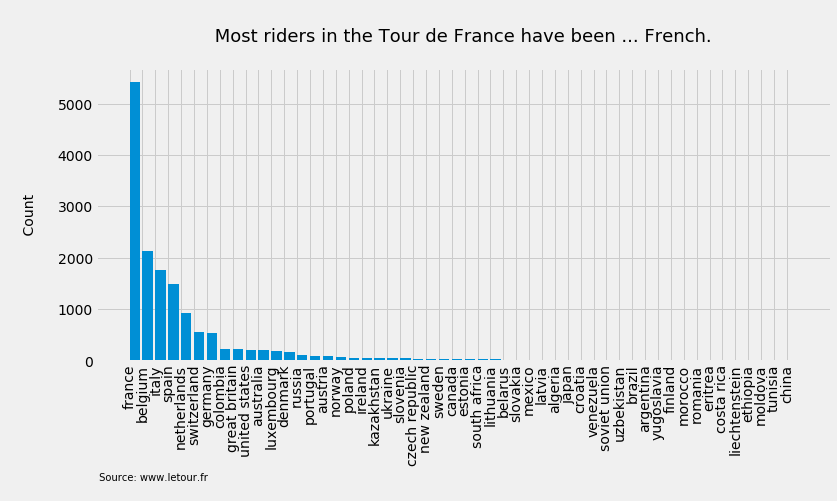

In [429]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111)
# plt.gcf().subplots_adjust(top=0.8, bottom=0.4, left=0.1)

data = m.country.value_counts(ascending=False)

# x = (range(len(data.index)))
# new_x = [2*i for i in x]

# for p in ax.patches:
#     ax.annotate("%.f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
#                  ha='center', va='center', fontsize=14, color='royalblue', xytext=(0, 16),
#                  textcoords='offset points')

# for i, val in enumerate(data.values):
#     ax.text(i, val + 50, str(val))
    
ax.bar(data.index, data.values, align='edge')
ax.set_title("\n Most riders in the Tour de France have been ... French. \n", size=18)
# France, unsurprisingly, has produced the most riders in the Tour de France...
ax.set_xticklabels(data.index, rotation=90)
plt.ylabel('\n Count \n', size=14)
plt.annotate('\n Source: www.letour.fr \n', (0,0), (0, -100), xycoords='axes fraction', textcoords='offset points', va='top', size=10)
plt.subplots_adjust(bottom=0.3, left=0.1)
plt.savefig(os.getcwd() + '/img/04_num_stages_over_time.png')

#### Make a percentage stacked area chart

In [83]:
yr_nat_pct = m.groupby(['year','country','ioc_code']).size().reset_index()
yr_nat_pct.columns = ['year','country','ioc_code','num_of_riders']
yr_nat_pct.head()

year      country ioc_code  num_of_riders
0  1903      belgium      bel              4
1  1903       france      fra             73
2  1903      germany      ger              2
3  1903        italy      ita              1
4  1903  switzerland      sui              4

In [84]:
yr_num_of_riders = m.groupby('year').size().reset_index()
yr_num_of_riders.columns = ['year','yearly_total_num_riders']
yr_num_of_riders.head()

year  yearly_total_num_riders
0  1903                       84
1  1904                       88
2  1905                       60
3  1906                       78
4  1907                       93

In [86]:
yr_nat_pct = pd.merge(yr_nat_pct, yr_num_of_riders, how='left',on='year')

In [97]:
print(yr_nat_pct.shape)
yr_nat_pct.head(10)

(1494, 6)


year      country ioc_code  num_of_riders  yearly_total_num_riders  \
0  1903      belgium      bel              4                       84   
1  1903       france      fra             73                       84   
2  1903      germany      ger              2                       84   
3  1903        italy      ita              1                       84   
4  1903  switzerland      sui              4                       84   
5  1904      belgium      bel             13                       88   
6  1904       france      fra             69                       88   
7  1904      germany      ger              1                       88   
8  1904        italy      ita              2                       88   
9  1904  switzerland      sui              3                       88   

    nat_pct  
0  0.047619  
1  0.869048  
2  0.023810  
3  0.011905  
4  0.047619  
5  0.147727  
6  0.784091  
7  0.011364  
8  0.022727  
9  0.034091

In [99]:
yr_nat_pct['nat_pct'] = yr_nat_pct.num_of_riders / yr_nat_pct.yearly_total_num_riders
yr_nat_pct.head()

year      country ioc_code  num_of_riders  yearly_total_num_riders  \
0  1903      belgium      bel              4                       84   
1  1903       france      fra             73                       84   
2  1903      germany      ger              2                       84   
3  1903        italy      ita              1                       84   
4  1903  switzerland      sui              4                       84   

    nat_pct  
0  0.047619  
1  0.869048  
2  0.023810  
3  0.011905  
4  0.047619

Create a base dataframe with all years between 1903 and 2019

In [239]:
all_years = pd.DataFrame(list(range(1903,2019)))
all_years.columns = ['year']
all_years.shape

(116, 1)

In [241]:
all_years_nat_pct = pd.merge(all_years, yr_nat_pct, how='left',on='year')
print(all_years_nat_pct.shape)
all_years_nat_pct.head(3)

(1505, 6)


year  country ioc_code  num_of_riders  yearly_total_num_riders   nat_pct
0  1903  belgium      bel            4.0                     84.0  0.047619
1  1903   france      fra           73.0                     84.0  0.869048
2  1903  germany      ger            2.0                     84.0  0.023810

In [242]:
pivoted_df = all_years_nat_pct.pivot(index='year', columns='country', values='nat_pct').T
pivoted_df.head()

year       1903  1904  1905  1906  1907  1908  1909  1910  1911  1912  ...  \
country                                                                ...   
NaN         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
algeria     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
argentina   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
australia   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
austria     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   

year           2009      2010      2011      2012      2013      2014  \
country                                                                 
NaN             NaN       NaN       NaN       NaN       NaN       NaN   
algeria         NaN       NaN       NaN       NaN       NaN       NaN   
argentina       NaN       NaN       NaN  0.005051       NaN  0.005051   
australia  0.038889  0.055556  0.030303  0.060606  0.055556  0.050505   
austria    0.011111  0.015152  0.005051  0.005051       NaN  0.005051   

year           2015      2016      2017      2018  
country                                            
NaN             NaN       NaN       NaN       NaN  
algeria         NaN       NaN       NaN       NaN  
argentina  0.005051  0.010101  0.005051  0.005682  
australia  0.050505  0.045455  0.045455  0.062500  
austria    0.015152  0.020202  0.015152  0.017045  

[5 rows x 116 columns]

In [317]:
labels_dict = {}
co_list = ['france', 'belgium', 'netherlands', 'italy', 'spain', 'germany',
           'australia', 'colombia', 'great britain', 'united states', 'switzerland']
color_list = ['darkblue','gold','darkorange','seagreen','firebrick','black',
              'darkgreen','salmon', 'grey','royalblue','red']

i = 0
ycoord_running_sum = 0
for country in co_list:
    data_pt = str(round(100 * pivoted_df.loc[country].tail(1).values[0], 1)) + '%'
    label = data_pt + '  ' + country.title()
    pct_in_2018 = pivoted_df.loc[country].tail(1).values[0]
    labels_dict[country] = {'label':label, 'color':color_list[i], 'ycoord':ycoord_running_sum + pct_in_2018/2 + 0.01}
    ycoord_running_sum = ycoord_running_sum + pct_in_2018
    
    i += 1
    
labels_dict

{'france': {'label': '19.9%  France',
  'color': 'darkblue',
  'ycoord': 0.10943181818181817},
 'belgium': {'label': '10.8%  Belgium',
  'color': 'gold',
  'ycoord': 0.26284090909090907},
 'netherlands': {'label': '8.0%  Netherlands',
  'color': 'darkorange',
  'ycoord': 0.3565909090909091},
 'italy': {'label': '7.4%  Italy',
  'color': 'seagreen',
  'ycoord': 0.43329545454545454},
 'spain': {'label': '7.4%  Spain',
  'color': 'firebrick',
  'ycoord': 0.5071590909090908},
 'germany': {'label': '6.2%  Germany',
  'color': 'black',
  'ycoord': 0.5753409090909091},
 'australia': {'label': '6.2%  Australia',
  'color': 'darkgreen',
  'ycoord': 0.6378409090909091},
 'colombia': {'label': '3.4%  Colombia',
  'color': 'salmon',
  'ycoord': 0.6861363636363637},
 'great britain': {'label': '2.8%  Great Britain',
  'color': 'grey',
  'ycoord': 0.7173863636363635},
 'united states': {'label': '2.8%  United States',
  'color': 'royalblue',
  'ycoord': 0.7457954545454545},
 'switzerland': {'label':

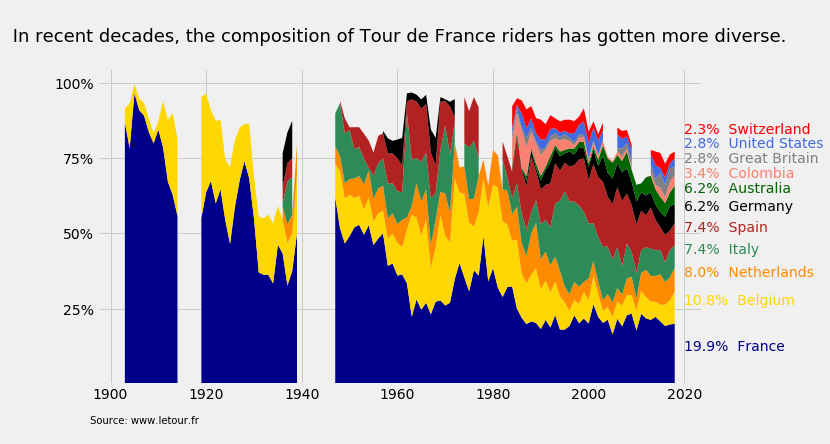

In [442]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
plt.subplots_adjust(bottom=0.15, left=0.15, right=0.85)

years = np.array(pivoted_df.columns)
countries = np.array(pivoted_df.loc[co_list].sort_values(2018, ascending=False))

j = 0
for country, info in labels_dict.items():
    if country in ['great britain','united states','switzerland']:
        j += 1
        ax.text(2020, info['ycoord'] + (0.02*j), info['label'], color=info['color'])
    else:
        ax.text(2020, info['ycoord'], info['label'], color=info['color'])

plt.stackplot(years, countries, colors=color_list, labels=labels)
# plt.legend(loc='lower right')
ax.set_yticks([.25,.5,.75,1])
ax.set_yticklabels(['25%','50%','75%','100%'])
ax.set_title('\n In recent decades, the composition of Tour de France riders has gotten more diverse. \n ', size=18)
plt.annotate('\n Source: www.letour.fr \n', (0,0), (-10, -20), xycoords='axes fraction', textcoords='offset points', va='top', size=10)
plt.savefig(os.getcwd() + '/img/05_nationality_mixture_over_time.png')
plt.show()

In the beginning, riders largely came from France and Beglium (until the late 1930s). Interesting how German riders don't return to the race until the late 1950s (took a decade to recover after WWII).

### Building a Chord Chart for city links

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
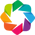

In [452]:
import holoviews as hv
from holoviews import opts, dim
from bokeh.sampledata.les_mis import data

hv.extension('bokeh')
hv.output(size=200)

In [468]:
nodes_sm = data['nodes'][:10]
nodes_sm

[{'name': 'Myriel', 'group': 1},
 {'name': 'Napoleon', 'group': 1},
 {'name': 'Mlle.Baptistine', 'group': 1},
 {'name': 'Mme.Magloire', 'group': 1},
 {'name': 'CountessdeLo', 'group': 1},
 {'name': 'Geborand', 'group': 1},
 {'name': 'Champtercier', 'group': 1},
 {'name': 'Cravatte', 'group': 1},
 {'name': 'Count', 'group': 1},
 {'name': 'OldMan', 'group': 1}]

In [470]:
links_sm = data['links'][:10]
links_sm

[{'source': 1, 'target': 0, 'value': 1},
 {'source': 2, 'target': 0, 'value': 8},
 {'source': 3, 'target': 0, 'value': 10},
 {'source': 3, 'target': 2, 'value': 6},
 {'source': 4, 'target': 0, 'value': 1},
 {'source': 5, 'target': 0, 'value': 1},
 {'source': 6, 'target': 0, 'value': 1},
 {'source': 7, 'target': 0, 'value': 1},
 {'source': 8, 'target': 0, 'value': 2},
 {'source': 9, 'target': 0, 'value': 1}]

In [454]:
links = pd.DataFrame(data['links'])
links.head(3)

source  target  value
0       1       0      1
1       2       0      8
2       3       0     10

In [466]:
print(stages_df.shape)
stages_df.tail()

(2259, 5)


year stage_num date_start start_city finish_city
2254  1903   Stage 2 1903-04-07       Lyon   Marseille
2255  1903   Stage 3 1903-08-07  Marseille    Toulouse
2256  1903   Stage 4 1903-12-07   Toulouse    Bordeaux
2257  1903   Stage 5 1903-07-13   Bordeaux      Nantes
2258  1903   Stage 6 1903-07-18     Nantes       Paris

In [459]:
hv.Chord(links)

:Chord   [source,target]   (value)

In [461]:
data['nodes'][:3]

[{'name': 'Myriel', 'group': 1},
 {'name': 'Napoleon', 'group': 1},
 {'name': 'Mlle.Baptistine', 'group': 1}]

In [460]:
nodes = hv.Dataset(pd.DataFrame(data['nodes']), 'index')
nodes.data.head()

index  group             name
0      0      1           Myriel
1      1      1         Napoleon
2      2      1  Mlle.Baptistine
3      3      1     Mme.Magloire
4      4      1     CountessdeLo

In [462]:
chord = hv.Chord((links, nodes)).select(value=(5, None))
chord.opts(
    opts.Chord(cmap='Category20', edge_cmap='Category20', edge_color=dim('source').str(), 
               labels='name', node_color=dim('index').str()))

:Chord   [source,target]   (value)